# Data Cleaning / Feature Engineering

By Ben Khoung

In [1]:
from nltk.stem.porter import *
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
import string 

## The Data

In [3]:
mbti = pd.read_csv('data/mbti_1.csv') # Original Dataframe
mbti_clean = mbti.copy() # Dataframe to be cleaned 
mbti_features = mbti.copy() # Dataframe to be populated with features
mbti_features.drop(columns=['posts'],inplace=True)

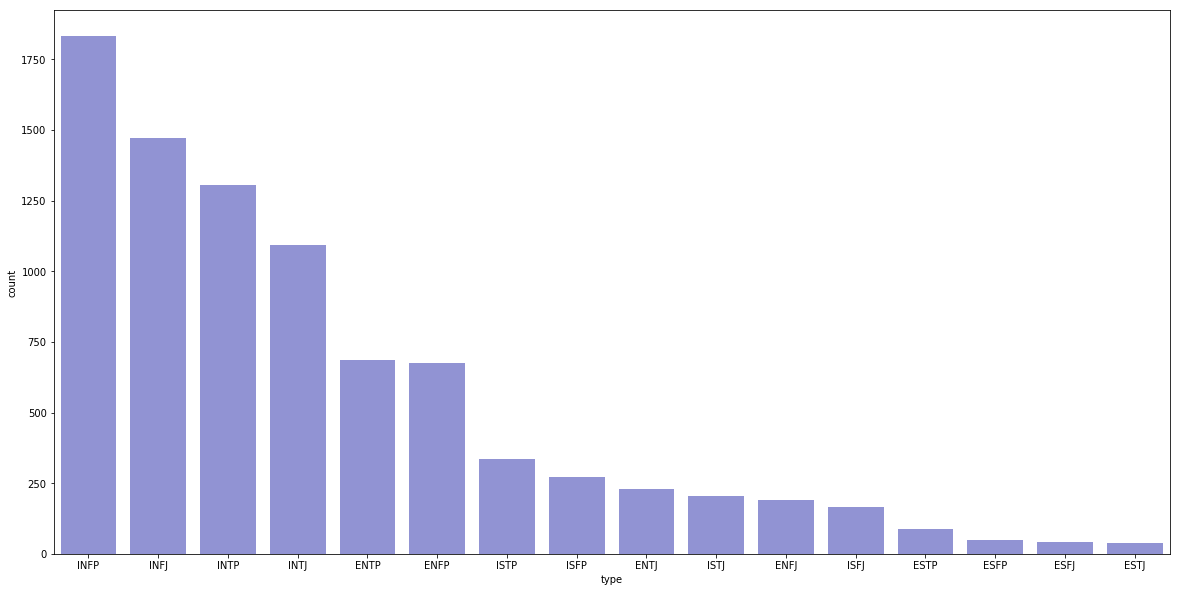

In [4]:
# Create Y Vector of classes 
y = mbti['type']
# Plot Class Count
plot = plt.figure(figsize=(20,10))
sns.countplot(y, color='#8689DE', order=y.value_counts().index)

## General Cleaning

**Removing Links:**

Remove all triple pipes because some links end at the end of a post which making it hard to find with regex. 

In [5]:
# For each user, remove ||| to make it easier to remove links. 
user_posts = [re.sub(r'\|\|\|',' ',posts) for posts in mbti['posts']] 
linkless_posts = [re.sub(r'http[\S]*','',posts) for posts in user_posts] # Remove all links. 
mbti_clean['posts'] = linkless_posts # Update mbti_clean 

**Lower Case**:

In [6]:
mbti_clean['posts'] = mbti_clean['posts'].str.lower() # Update mbti_clean 

## Word Count 

Strip all punctuations and numbers:

In [7]:
# Strip all punctuation. Returns a list of strings 
posts_without_punct = [re.sub(r'[^a-z\s]','',posts) for posts in mbti_clean['posts']]
# Split each element in the list into a list of words. Returns a list of lists 
words = [posts.split() for posts in posts_without_punct]

Stem words, remove stop words, and remove words less than 3 characters in length.

**Caution:** Takes a few minutes to run

In [8]:
## CAUTION: STEMMING WORDS TAKES A FEW MINUTES. UNCOMMENT TO RE-RUN
# Stem words, remove stop words and words less than 3 characters
stemmer = PorterStemmer()
for row in range(len(words)):
    words[row] = " ".join([stemmer.stem(word) for word in words[row] if word not in list(stop_words.ENGLISH_STOP_WORDS) and len(word) >= 3])


Create a bag of words representation of each user 

In [9]:
# Chose CountVectorizer with min_df = 25 because there were some odd cases like 'aaaaa' 
vectorizer = CountVectorizer(min_df=25)
word_count = vectorizer.fit_transform(words)
# Create word_count dataframe 
word_count_df = pd.DataFrame(data = word_count.toarray(), columns = vectorizer.get_feature_names())
word_count_df.insert(loc=0, column='true_type', value=mbti['type'])
word_count_df.head()

,true_type,aback,abandon,abbey,abbrevi,abhor,abid,abil,abit,abl,...,yup,zealand,zelda,zen,zero,zodiac,zombi,zone,zoo,zoom
0,INFJ,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ENTP,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,INTP,0,0,0,0,0,0,2,0,1,...,1,0,0,0,0,0,0,0,0,0
3,INTJ,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
4,ENTJ,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Save to CSV:

In [10]:
word_count_df.to_csv('word_count_ben')

Visualize Word Cloud

In [11]:
class_word_count = word_count_df.groupby('true_type').sum() # Sum words by class 

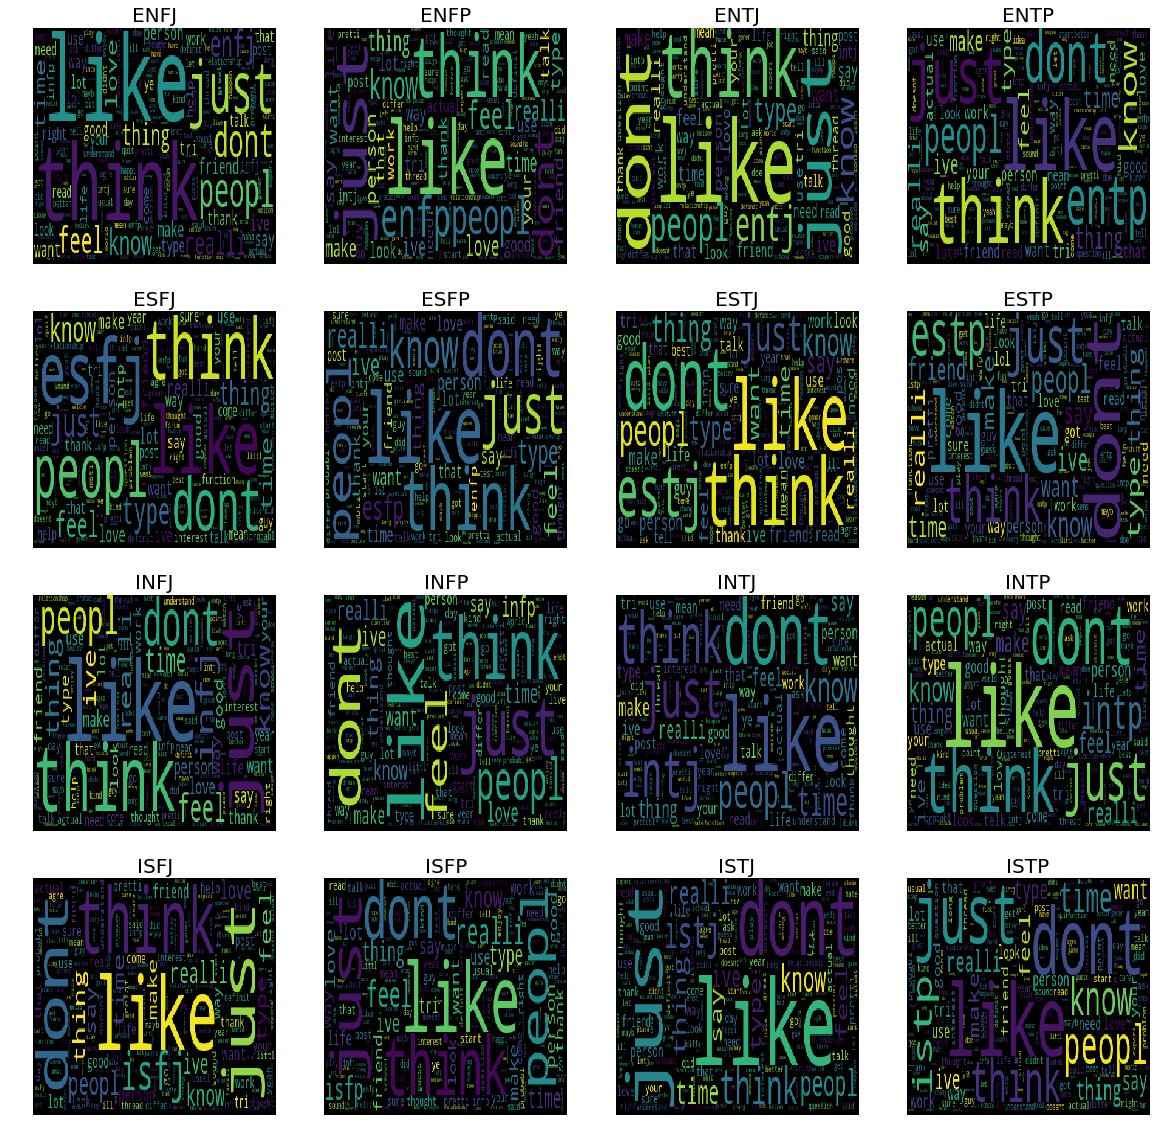

In [12]:
fig = plt.figure(figsize=(20,20)) # Set Plot Size 

for i in range(len(class_word_count)):
    word_dict = {i:v for i,v in class_word_count.iloc[i].iteritems()} # Create dictionary with word:count 
    wordcloud = WordCloud()
    wordcloud.fit_words(word_dict) 
    plt.subplot(4,4,i+1) # Set 4x4 subplots 
    plt.imshow(wordcloud, aspect='auto')
    plt.axis("off")
    plt.title(class_word_count.index[i], fontsize=20)
    
plt.show()

## Average Sentiment Score Across Posts

**Caution:** Takes a few minutes to run

In [16]:
mbti['split_posts'] = mbti['posts'].apply(lambda x: x.split("|||"))

In [33]:
analyzer = SentimentIntensityAnalyzer()

total_compound_score = []
for i in range(len(mbti)):
    score = pd.Series([analyzer.polarity_scores(post)['compound'] for post in mbti['split_posts'].iloc[i]]).mean()
    total_compound_score.append(score)
    
mbti_features['compound_score'] = total_compound_score


In [40]:
total_pos_score = []
for i in range(len(posts_without_punct)):
    score = pd.Series([analyzer.polarity_scores(post)['pos'] for post in mbti['split_posts'].iloc[i]]).mean()
    total_pos_score.append(score)
mbti_features['pos_score'] = total_pos_score

In [41]:
total_neg_score = []
for i in range(len(posts_without_punct)):
    score = pd.Series([analyzer.polarity_scores(post)['neg'] for post in mbti['split_posts'].iloc[i]]).mean()
    total_neg_score.append(score)
mbti_features['neg_score'] = total_neg_score

In [42]:
total_neu_score = []
for i in range(len(posts_without_punct)):
    score = pd.Series([analyzer.polarity_scores(post)['neu'] for post in mbti['split_posts'].iloc[i]]).mean()
    total_neu_score.append(score)
mbti_features['neu_score'] = total_neu_score

## Ellipses Count

Counting number of ellipsies used per user.

In [43]:
# Create a list of ellpsies count per user. This is an indicator for long posts 
ellipses_count = [len(re.findall(r'\.\.\.\ ',posts)) for posts in mbti_clean['posts']]
# Append to dataset 
mbti_features['ellipses'] = ellipses_count

## Exclamation Count
Counting number of exclamation marks used per user. 

In [44]:
# Create a list of exclamation count per user. 
exclamation_count = [len(re.findall(r'!',posts)) for posts in mbti_clean['posts']]
# Append to features dataframe
mbti_features['exclamation'] = exclamation_count

## Question Count
Counting number of question marks used per user. 

In [45]:
# Create a list of question count per user. 
question_count = [len(re.findall(r'\?',posts)) for posts in mbti_clean['posts']]
# Append to features dataframe
mbti_features['question'] = question_count

## Link Count 
Counting number of links used per user. 

In [46]:
# For each user, remove ||| to make it easier to find links. 
user_posts = [re.sub(r'\|\|\|',' ',posts) for posts in mbti['posts']]
# Create a list of link count per user. 
link_count = [len(re.findall(r'http', posts)) for posts in user_posts]
# Append to features dataframe
mbti_features['links'] = link_count

## Features Table

In [47]:
mbti_features.head()

,type,compound_score,pos_score,neg_score,neu_score,ellipses,exclamation,question,links
0,INFJ,0.039360,0.08786,0.05676,0.85536,15,3,2,24
1,ENTP,0.325814,0.18538,0.05728,0.75744,18,0,4,10
2,INTP,0.214150,0.14590,0.05990,0.79422,13,4,9,5
3,INTJ,0.174424,0.10954,0.05558,0.83484,26,3,9,2
4,ENTJ,0.035890,0.12440,0.11368,0.76190,21,1,8,6


In [58]:
mbti_features.to_csv('mbti_features_ben.csv')

## Links

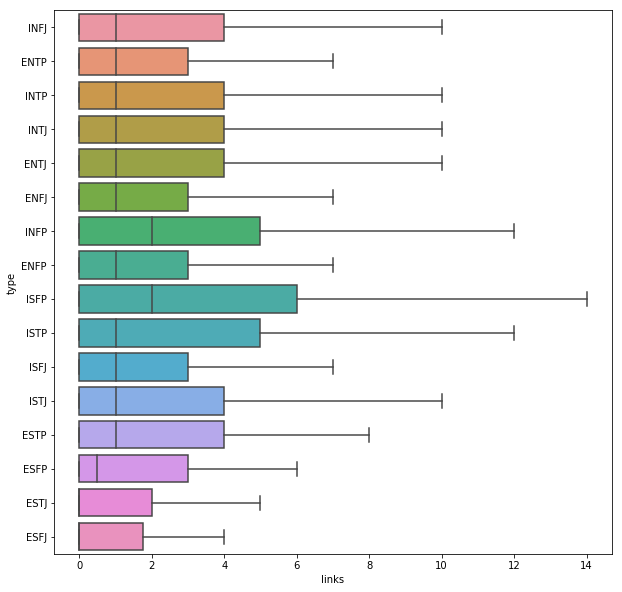

In [48]:
plt.figure(figsize=(10,10))
sns.boxplot(y='type', x='links', data=mbti_features, showfliers=False)

## Question Marks

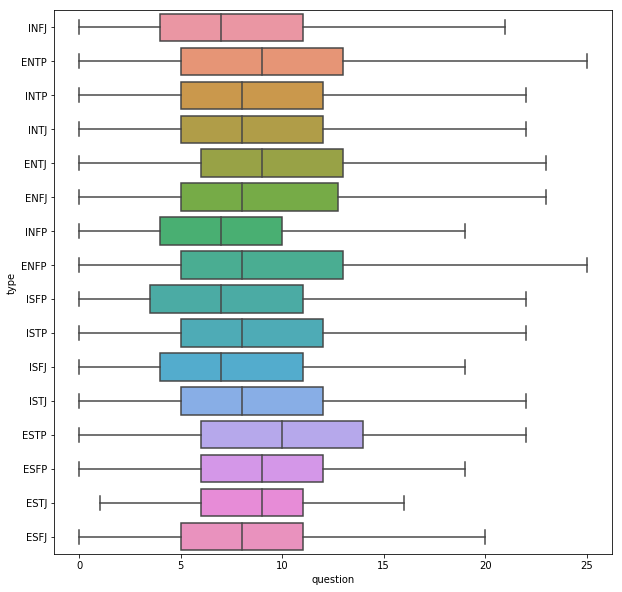

In [49]:
plt.figure(figsize=(10,10))
sns.boxplot(y='type', x='question', data=mbti_features, showfliers=False)

## Exclamation Marks

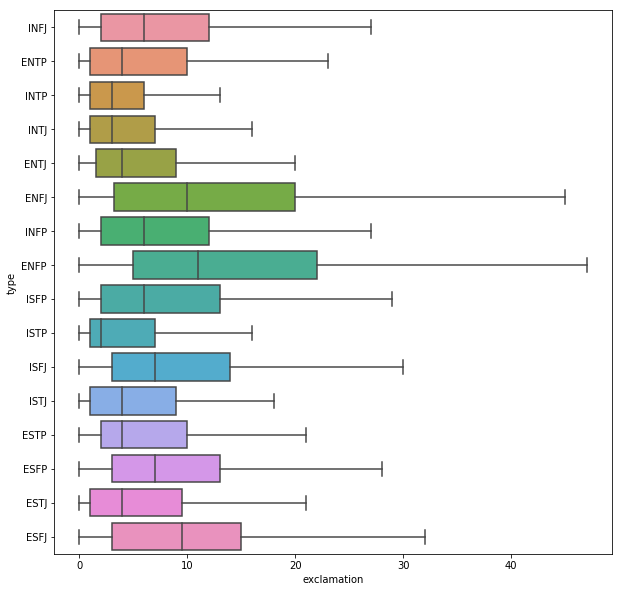

In [50]:
plt.figure(figsize=(10,10))
sns.boxplot(y='type', x='exclamation', data=mbti_features, showfliers=False)

## Ellipses

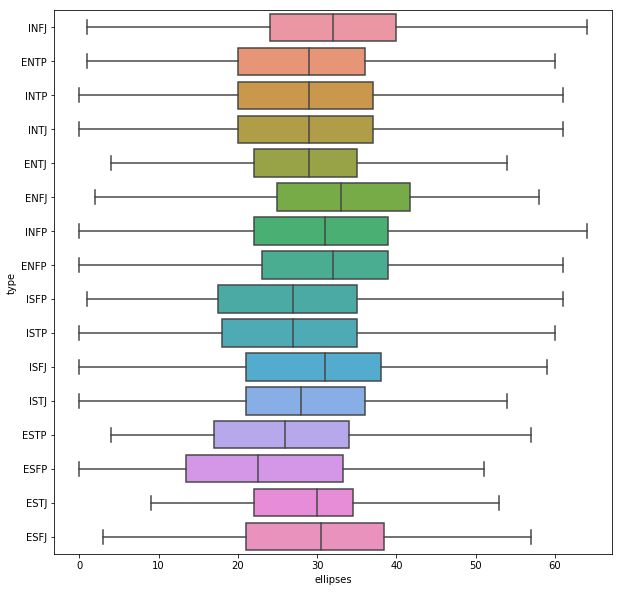

In [51]:
plt.figure(figsize=(10,10))
sns.boxplot(y='type', x='ellipses', data=mbti_features, showfliers=False)

## Sentiment Score

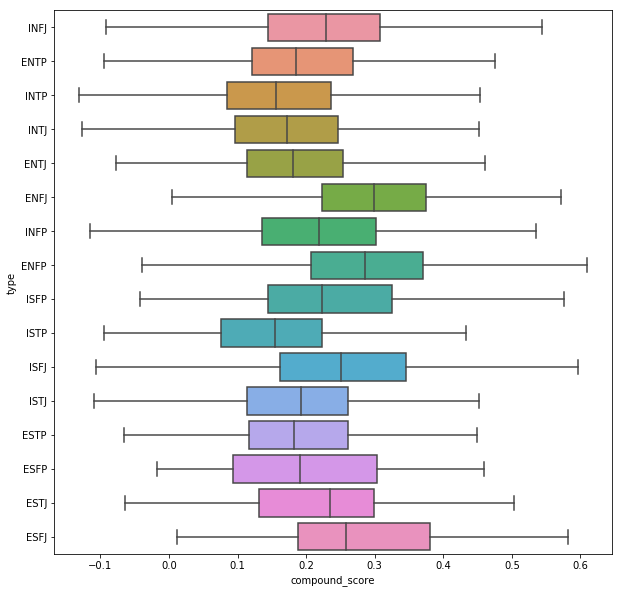

In [53]:
plt.figure(figsize=(10,10))
sns.boxplot(y='type', x='compound_score', data=mbti_features, showfliers=False)

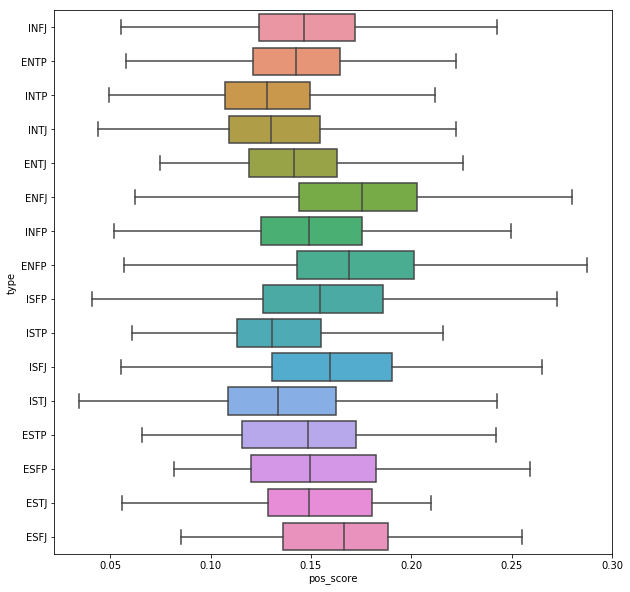

In [55]:
plt.figure(figsize=(10,10))
sns.boxplot(y='type', x='pos_score', data=mbti_features, showfliers=False)

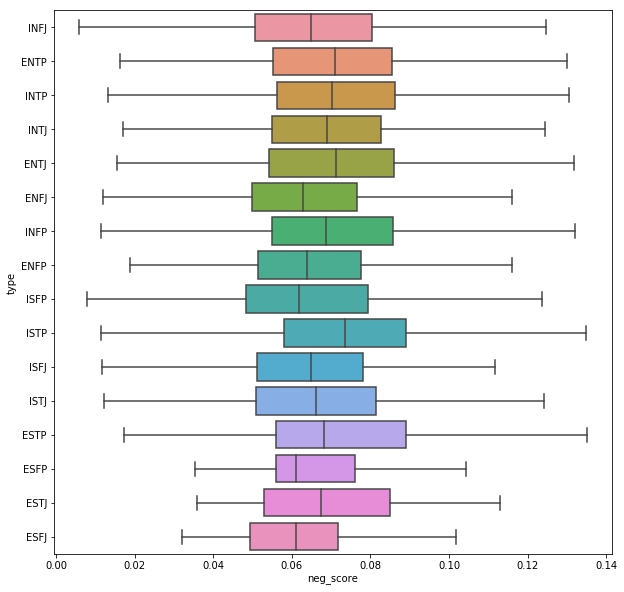

In [56]:
plt.figure(figsize=(10,10))
sns.boxplot(y='type', x='neg_score', data=mbti_features, showfliers=False)

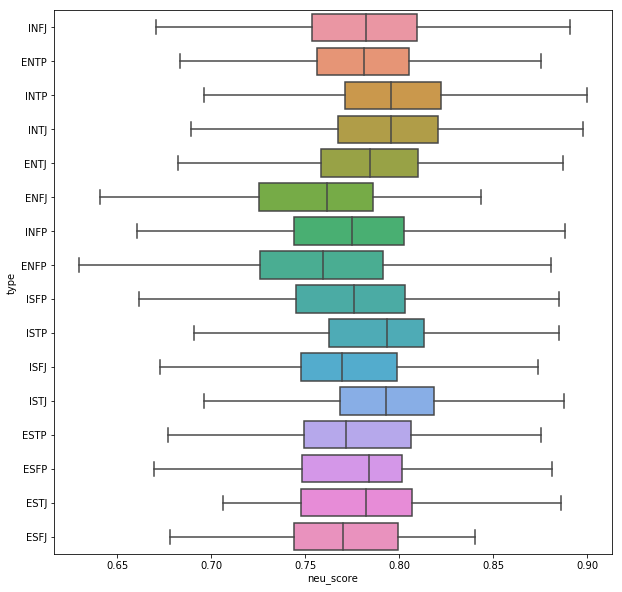

In [57]:
plt.figure(figsize=(10,10))
sns.boxplot(y='type', x='neu_score', data=mbti_features, showfliers=False)

## Additional Features to Consider:

* Sentence Length
* N grams (or is this more of a step tuning with count vectorizer? 